In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
import skimage

from src.models import InputImage
from src.filters import yen_th, sobel
from skimage.morphology import disk, binary_closing, binary_opening, convex_hull_image

# Searching well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Creating mask for well
_____________________________________________________________
# Searching fish properties
_____________________________________________________________
# Creating fish convex mask
_____________________________________________________________
# Applying Yen-thresholding
_____________________________________________________________
# Stored binary image in object
_____________________________________________________________
# Getting convex hull for fish
_____________________________________________________________
# Stored fish mask & bounding box
_____________________________________________________________


Text(0.5, 1.0, 'Fish masked')

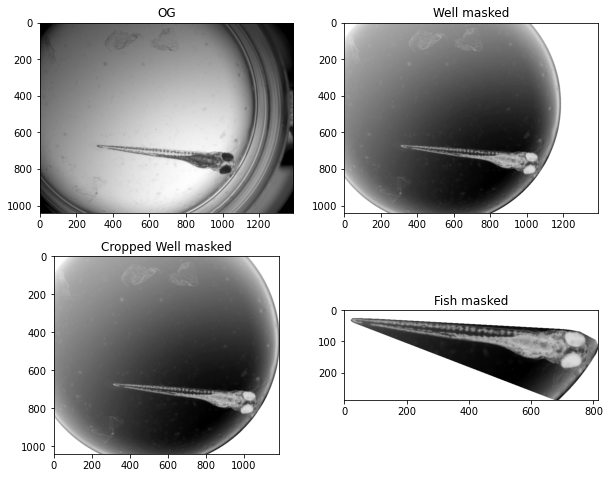

In [3]:
from src.fish.find_fish_props import find_fish_props
from src.well.find_well_props import find_well_props

fishy = InputImage("zf2.jpg")
fishy = find_well_props(fishy)
fishy = find_fish_props(fishy)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = ax.ravel()

ax[0].imshow(fishy.og, "binary")
ax[0].set_title('OG')
ax[1].imshow(fishy.well_props.mask.masked, "binary")
ax[1].set_title('Well masked')
ax[2].imshow(fishy.well_props.mask.cropped_masked, "binary")
ax[2].set_title('Cropped Well masked')
ax[3].imshow(fishy.fish_props.mask.cropped_masked, "binary")
ax[3].set_title('Fish masked')

Text(0.5, 1.0, 'W/O BG')

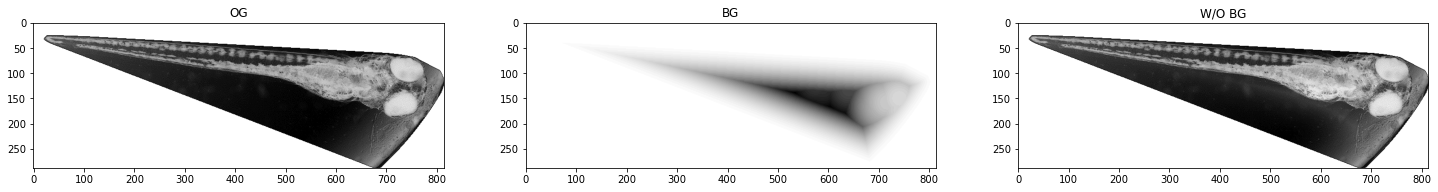

In [4]:
from src.filters import sharpen_img
from skimage.restoration import rolling_ball
from skimage.exposure import equalize_hist, equalize_adapthist

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 20))
ax = ax.ravel()

og = fishy.fish_props.mask.cropped_masked
shp = sharpen_img(og)
bg = rolling_ball(shp)
res = shp - bg

"""res = equalize_adapthist(res)
og = equalize_adapthist(og)"""

ax[0].imshow(shp, "binary")
ax[0].set_title('OG')
ax[1].imshow(bg, "binary")
ax[1].set_title('BG')
ax[2].imshow(res, "binary")
ax[2].set_title('W/O BG')

Text(0.5, 1.0, 'iso')

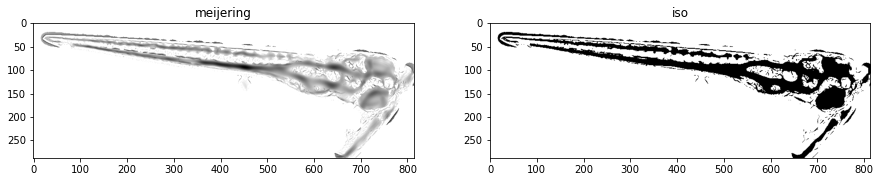

In [4]:
from skimage.filters.ridges import meijering
from skimage.filters.thresholding import threshold_isodata, threshold_li, threshold_minimum

eq_res = equalize_adapthist(res)
mej = meijering(eq_res) * fishy.fish_props.mask.cropped

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax = ax.ravel()

ax[0].imshow(mej, "binary")
ax[0].set_title('meijering')
ax[1].imshow(mej > threshold_isodata(mej), "binary")
ax[1].set_title('iso')

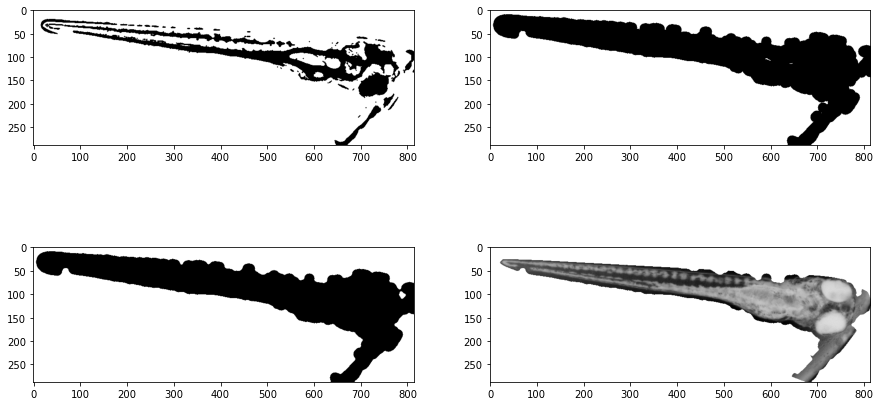

In [5]:
from src.utils import keep_largest_object
from skimage.morphology import square, binary_dilation, black_tophat, white_tophat, convex_hull_object
from scipy import ndimage

iso_threshold = mej > threshold_isodata(mej)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
ax = ax.ravel()

o = binary_opening(iso_threshold)
d = binary_dilation(o, disk(10))
c = binary_closing(d, disk(3))

lrg = ndimage.binary_fill_holes(keep_largest_object(c))

fsh = (lrg * fishy.fish_props.mask.cropped_masked)

ax[0].imshow(o, "binary")
ax[1].imshow(d, "binary")
ax[2].imshow(c, "binary")
ax[3].imshow(fsh, "binary")

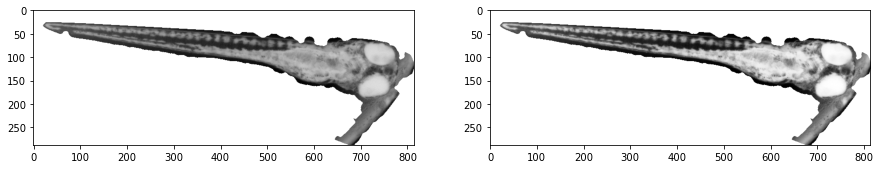

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax = ax.ravel()

eq_fsh = equalize_hist(fsh)


ax[0].imshow(fsh, "binary")
ax[1].imshow(eq_fsh, "binary")
